In [48]:
source('helpers.R')
kaggle.house.loadLibraries()

df.combined = kaggle.house.PrepareCombinedDataSet()
df.lot_frontage = df.combined %>% filter(!is.na(LotFrontage))

df.lot_frontage.trimmed = df.lot_frontage %>%
    mutate(
        LotArea.Log.normed = abs(LotArea.Log - mean(LotArea.Log)) / sd(LotArea.Log),
        LotArea.Log.isOutlier = LotArea.Log.normed >= 3) %>%
    filter(LotArea.Log.isOutlier == FALSE) %>%
    select(-LotArea.Log.isOutlier)

df.lot_frontage %>% count()
df.lot_frontage.trimmed %>% count()

n
2433


n
2368


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.5871939,0.5870241,0.2299065,3457.964,0,2,125.4342,-244.8685,-227.4778,128.4953,2431


term,estimate,std.error,statistic,p.value
(Intercept),-0.8169321,0.085101273,-9.599528,1.917586e-21
LotArea.Log,0.5512073,0.009373564,58.804455,0.000000e+00


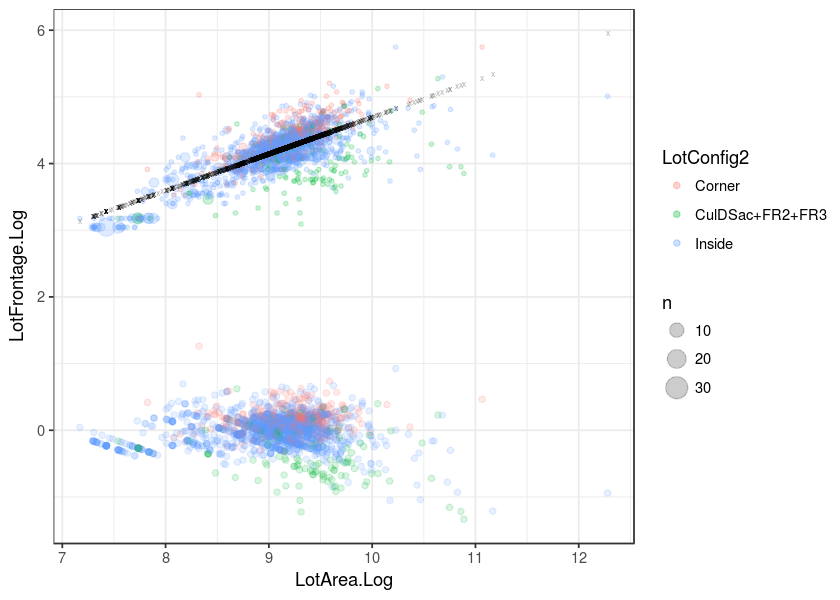

In [49]:
options(repr.plot.width = 7, repr.plot.height = 5)

model = df.lot_frontage %>% 
    do(mod = lm(LotFrontage.Log ~ LotArea.Log, data=.))

fitted = df.lot_frontage %>% 
    do(augment(lm(LotFrontage.Log ~ LotArea.Log, data=.), data = .))

model %>% glance(mod)
model %>% tidy(mod)

ggplot() +
    geom_count(data=fitted, aes(x=LotArea.Log, y=LotFrontage.Log, colour = LotConfig2), alpha=0.2) +
    geom_point(data=fitted, aes(x=LotArea.Log, y=.fitted), alpha=0.3, color="black", shape='x') +
    geom_point(data=fitted, aes(x=LotArea.Log, y=.resid, colour=LotConfig2), alpha=0.15) +
    theme_bw()

In [163]:
rsquaredSplit = function (df.data) {
    colNames = names(which(sapply(df.data, is.character)))
    colNames = c(colNames, "LotFrontage.Log", "LotArea.Log")

    df.rsquared = df.data %>% 
        select(colNames) %>% 
        gather(attr, attr_val, -LotFrontage.Log, -LotArea.Log) %>% 
        group_by(attr, attr_val) %>%
        do(glance(lm(LotFrontage.Log ~ LotArea.Log, data=.))) %>%
        select(attr, attr_val, r.squared)

    df.freq = df.data %>% 
        select(colNames) %>% 
        gather(attr, attr_val, -LotFrontage.Log, -LotArea.Log) %>% 
        group_by(attr, attr_val) %>%
        summarise(n=n()) %>%
        mutate(freq = n / sum(n))

    df.joint = inner_join(df.rsquared, df.freq, by = c("attr", "attr_val"))
    df.joint %>% 
        mutate(freq.rsquared = r.squared * freq) %>% 
        group_by(attr) %>%
        summarise(rsquared.expect = sum(freq.rsquared)) %>%
        arrange(desc(rsquared.expect))   
}

rsquaredSplit2 = function (df.data) {
    colNames = names(which(sapply(df.data, is.character)))
    colNames = c(colNames, "LotFrontage.Log", "LotArea.Log")

    df.rsquared = df.data %>% 
        select(colNames) %>% 
        gather(attr, attr_val, -LotFrontage.Log, -LotArea.Log) %>% 
        group_by(attr, attr_val) %>%
        do(glance(lm(LotFrontage.Log ~ LotArea.Log, data=.))) %>%
        mutate(n = df + df.residual) %>%
        select(attr, attr_val, r.squared, n) %>% 
        group_by(attr) %>% 
        mutate(freq = n / sum(n), freq.rsquared = r.squared * freq) %>%
        summarise(rsquared.expect = sum(freq.rsquared)) %>%
        arrange(desc(rsquared.expect))

    df.rsquared
}

rsquaredSplit(df.lot_frontage) %>% head(5)
rsquaredSplit2(df.lot_frontage) %>% head(5)

attr,rsquared.expect
LotConfig,0.6512306
LotConfig2,0.6454040
LotShape,0.6092392
LotShape2,0.6000610
LandSlope,0.5976722


attr,rsquared.expect
LotConfig,0.6512306
LotConfig2,0.6454040
LotShape,0.6092392
LotShape2,0.6000610
LandSlope,0.5976722


In [88]:
kaggle.house.lineaModelSplitByCategoricalAttrs = function (lm.formula) {

}

lm.formula = LotFrontage.Log ~ LotArea.Log

x = terms(lm.formula)
y = attr(x, "variables")
z = as.list(y)[-1]
w = z[[1]]
w

LotFrontage.Log

LotConfig2,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Corner,0.6090078,0.6080424,0.1823055,630.82623,1.315209e-84,2,116.23758,-226.4752,-214.4487,13.46029,405
CulDSac+FR2+FR3,0.2875249,0.2831269,0.3564402,65.37638,1.365161e-13,2,-62.51919,131.0384,140.3380,20.58203,162
Inside,0.6848806,0.6847112,0.1959327,4042.52482,0.000000e+00,2,393.96767,-781.9353,-765.3471,71.40467,1860


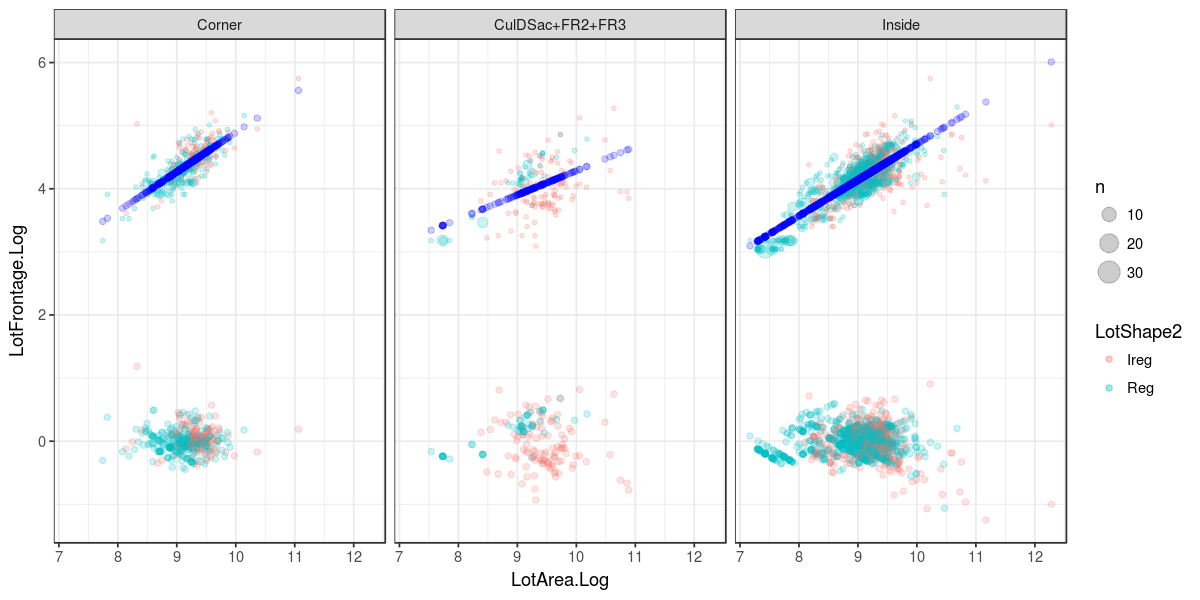

In [39]:
options(repr.plot.width = 10, repr.plot.height = 5)

models = df.lot_frontage %>% 
    group_by(LotConfig2) %>% 
    do(mod = lm(LotFrontage.Log ~ LotArea.Log, data=.))

fitted = df.lot_frontage %>% 
    group_by(LotConfig2) %>% 
    do(augment(lm(LotFrontage.Log ~ LotArea.Log, data=.), data = .))

models %>% glance(mod)

ggplot() +
    geom_count(data=fitted, aes(x=LotArea.Log, y=LotFrontage.Log, colour=LotShape2), alpha=0.2) +
    geom_point(data=fitted, aes(x=LotArea.Log, y=.fitted), alpha=0.2, color="blue") +
    geom_point(data=fitted, aes(x=LotArea.Log, y=.resid, colour=LotShape2), alpha=0.2) +
    facet_wrap(~LotConfig2) +
    theme_bw()

In [104]:
df.inside = 
    df.lot_frontage %>% 
    filter(LotConfig2 == 'Inside')

rsquaredSplit(df.inside) %>% head(10)

attr,rsquared.expect
LandContour,0.6951288
RoofMatl,0.6933967
LandSlope,0.6933320
Heating,0.6901588
SaleType,0.6866277
Street,0.6861063
BsmtExposure,0.6856591
LotConfig,0.6848806
LotConfig2,0.6848806
dataSource,0.6844973


LotShape2,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Ireg,0.3351010,0.3336680,0.2468782,233.8503,4.823367e-43,2,-8.3543,22.7086,35.14116,28.28026,464
Reg,0.7762946,0.7761341,0.1692025,4837.4103,0.000000e+00,2,500.3782,-994.7565,-979.03236,39.90952,1394


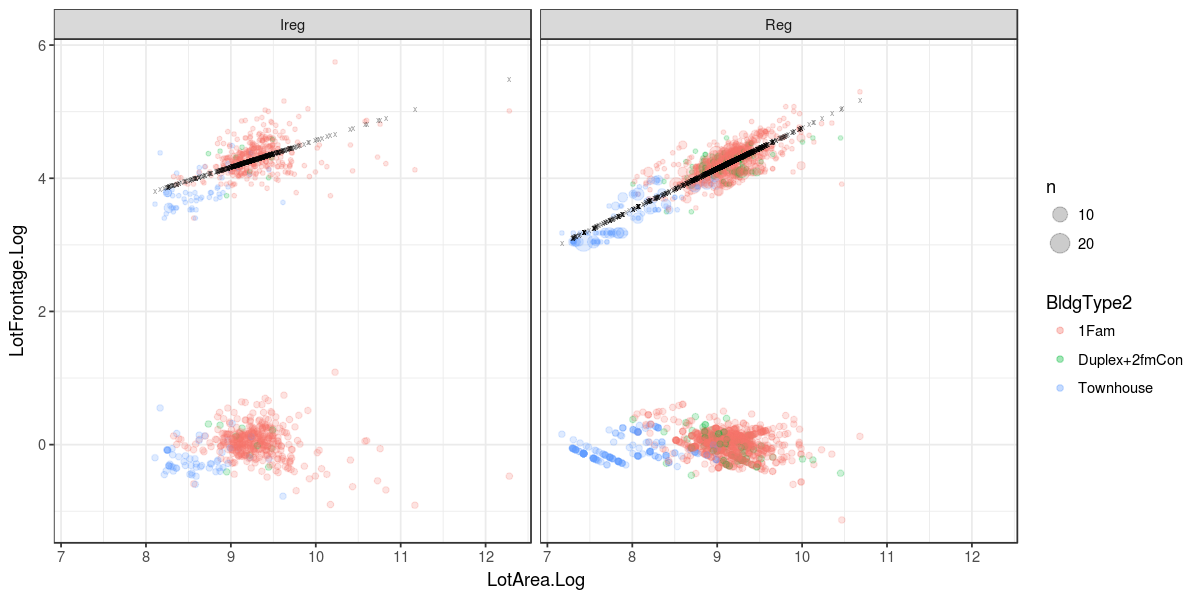

In [106]:
options(repr.plot.width = 10, repr.plot.height = 5)

df.inside = 
    df.lot_frontage %>% 
    filter(LotConfig2 == 'Inside') %>% 
    group_by(LotShape2)

models = df.inside %>% 
    do(mod = lm(LotFrontage.Log ~ LotArea.Log, data=.))

fitted = df.inside %>% 
    do(augment(lm(LotFrontage.Log ~ LotArea.Log, data=.), data = .))

models %>% glance(mod)

ggplot() +
    geom_count(data=fitted, aes(x=LotArea.Log, y=LotFrontage.Log, colour=BldgType2), alpha=0.2) +
    geom_point(data=fitted, aes(x=LotArea.Log, y=.fitted), alpha=0.4, color="black", shape='x') +
    geom_point(data=fitted, aes(x=LotArea.Log, y=.resid, colour=BldgType2), alpha=0.2) +
    facet_wrap(~LotShape2) +
    theme_bw()

LotShape2,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Ireg,0.4533217,0.4490508,0.2036356,106.1413,1.698953e-18,2,23.4308,-40.86159,-32.25899,5.307833,128
Reg,0.6240206,0.6226534,0.1662642,456.4230,2.335617e-60,2,104.9448,-203.88950,-193.01745,7.602040,275


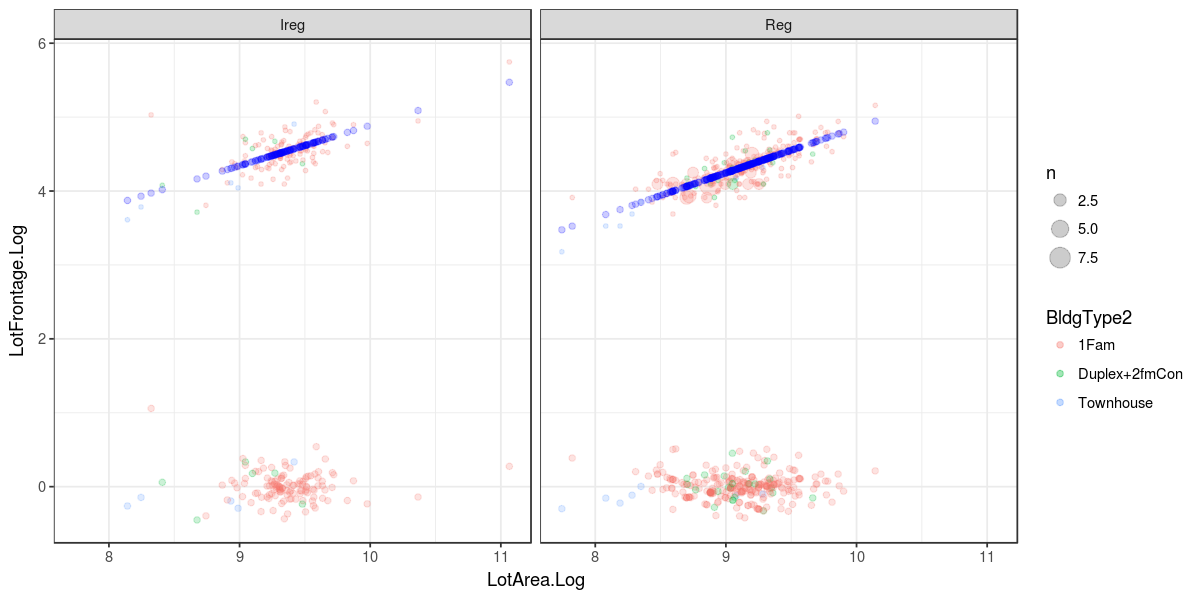

In [47]:
options(repr.plot.width = 10, repr.plot.height = 5)


df.corner = 
    df.lot_frontage %>% 
    filter(LotConfig2 == 'Corner') %>% 
    group_by(LotShape2)

models = df.corner %>% 
    group_by(LotShape2) %>% 
    do(mod = lm(LotFrontage.Log ~ LotArea.Log, data=.))

fitted = df.corner %>% 
    group_by(LotShape2) %>% 
    do(augment(lm(LotFrontage.Log ~ LotArea.Log, data=.), data = .))

models %>% glance(mod)

ggplot() +
    geom_count(data=fitted, aes(x=LotArea.Log, y=LotFrontage.Log, colour=BldgType2), alpha=0.2) +
    geom_point(data=fitted, aes(x=LotArea.Log, y=.fitted), alpha=0.2, color="blue") +
    geom_point(data=fitted, aes(x=LotArea.Log, y=.resid, colour=BldgType2), alpha=0.2) +
    facet_wrap(~LotShape2) +
    theme_bw()

LotShape2,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Ireg,0.3517496,0.3136173,0.3529301,9.224436,7.440346e-03,2,-6.114967,18.22993,21.06325,2.117514,17
Reg,0.2683104,0.2626820,0.1631786,47.670966,2.006807e-10,2,53.011910,-100.02382,-91.37541,3.461542,130


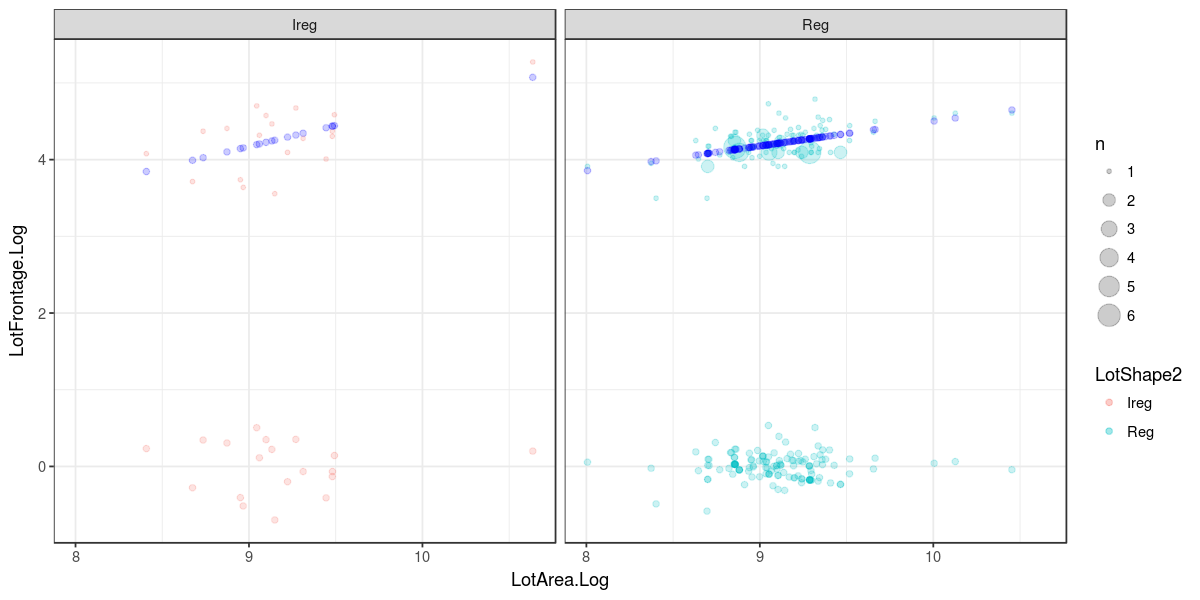

In [15]:
options(repr.plot.width = 10, repr.plot.height = 5)


df.duplex = 
    df.lot_frontage %>% 
    filter(BldgType2 == 'Duplex+2fmCon') %>% 
    group_by(LotShape2)

models = df.duplex %>% 
    group_by(LotShape2) %>% 
    do(mod = lm(LotFrontage.Log ~ LotArea.Log, data=.))

fitted = df.duplex %>% 
    group_by(LotShape2) %>% 
    do(augment(lm(LotFrontage.Log ~ LotArea.Log, data=.), data = .))

models %>% glance(mod)

ggplot() +
    geom_count(data=fitted, aes(x=LotArea.Log, y=LotFrontage.Log, colour=LotShape2), alpha=0.2) +
    geom_point(data=fitted, aes(x=LotArea.Log, y=.fitted), alpha=0.2, color="blue") +
    geom_point(data=fitted, aes(x=LotArea.Log, y=.resid, colour=LotShape2), alpha=0.2) +
    facet_wrap(~LotShape2) +
    theme_bw()